# From images to semantic search: Building a Snack Specialist Store in minutes

Experience the power of AI and data analytics to create a personalized snack shopping experience like never before. In this live demo, we'll unveil how to build a Snack Specialist Store application in mere minutes, harnessing cutting-edge technologies:

Key Highlights:

- Unleash the Potential of Unstructured Data:
  - BigQuery Integration: Seamlessly connect to your image dataset of snacks stored in BigQuery.
  - Image Analysis: Extract valuable information from snack images – brand, flavor, ingredients, and more.

- Elevate with Generative AI:
  - Dynamic Content Creation: Generate captivating snack descriptions, reviews, or even personalized recommendations based on extracted image details.

- Intuitive Search, Visual & Textual:
  - Semantic Search: Empower users to find their perfect snack through text-based or image-based queries.
  - Visual Similarity: Surface snacks that look similar to a reference image or match specific visual attributes.
  - Textual Relevance: Deliver accurate results based on keywords, flavor profiles, dietary needs, and more.


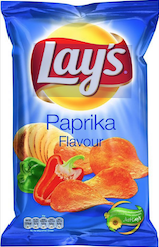
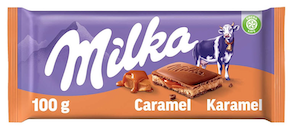
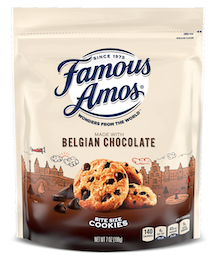

## Overview

The objective is to demonstrate how to use the Gemini models for analysis in BigQuery, including:


*   Completing setup steps for accessing Vertex AI (including Gemini models) from BigQuery
*   Creating an Object Table for the unstructured dataset being analyzed
*   Creating the remote models in BigQuery for Gemini 1.0 Pro and Gemini 1.0 Pro Vision
*   Performing analysis over the object table using the Gemini models
*   Joining analysis results back to structured table for deeper insights

## Services and Costs

This tutorial uses the following Google Cloud data analytics and ML services, they are billable components of Google Cloud:

* BigQuery & BigQuery ML [(pricing)](https://cloud.google.com/bigquery/pricing)
* Vertex AI API [(pricing)](https://cloud.google.com/vertex-ai/pricing)

Use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Setup steps
First, let's setup the environemnt and prepare all necessary objects.

### Enable the Vertex AI and BigQuery Connection APIs

In [ ]:
!gcloud services enable aiplatform.googleapis.com bigqueryconnection.googleapis.com

Operation "operations/acat.p2-458398081798-e03f58f7-98f7-4092-bcb7-516c7a82ddba" finished successfully.


## Create a Cloud resource connection and grant it the necessary permissions

Grant the "Vertex AI User" role to the service account used by the Cloud resource connection.

*Note: This demo analyzes a dataset that sits in a public Cloud Storage bucket. When analyzing a dataset in a non-public bucket, the service account will also need "Storage Object Viewer" role on that storage bucket.*

In [78]:
# create an external connection to allow access to Vertex AI services and GCS buckets
!bq mk --connection --location=us \
    --connection_type=CLOUD_RESOURCE gemini_conn

SERVICE_ACCT = !bq show --format=prettyjson --connection us.gemini_conn | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]

import os

PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"]

# add permission to call vertex AI gemini model
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role=roles/aiplatform.user

# add permission to access GCS bucket for external table
!gcloud projects add-iam-policy-binding --format=none $PROJECT_ID --member=serviceAccount:$SERVICE_ACCT_EMAIL --role=roles/storage.objectUser

Connection 458398081798.us.gemini_conn successfully created
Updated IAM policy for project [lohk-da-coaching].
Updated IAM policy for project [lohk-da-coaching].


In [80]:
# create a new dataset
%%bigquery
CREATE SCHEMA
  `lohk-da-coaching.snack_specialist` OPTIONS (location = 'US');

# create gemini vision pro model
CREATE OR REPLACE  MODEL `snack_specialist.gemini_pro_vision_model`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS(endpoint = 'gemini-pro-vision');

# create text embedding model
CREATE OR REPLACE  MODEL `snack_specialist.embedding_model`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS(endpoint = 'textembedding-gecko');

Query is running:   0%|          |

""


## Use object table to access image files (unstructured data) in BigQuery

Create a new object table to point to the images of snacks in a storage bucket

In [84]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE `snack_specialist.snack_object_table`
WITH CONNECTION `us.gemini_conn`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['gs://lohk-da-demo/snacks/*']
);

SELECT * FROM `snack_specialist.snack_object_table` LIMIT 100;


Query is running:   0%|          |

Downloading:   0%|          |

,uri,generation,content_type,size,md5_hash,updated,metadata
0,gs://lohk-da-demo/snacks/MnM-peanut.jpg,1717058359858050,image/jpeg,610855,ccb2bb88e6cd2357c703009da72c35ca,2024-05-30 08:39:19.892000+00:00,[]
1,gs://lohk-da-demo/snacks/Pocky Strawberry 70g_...,1717058360363535,image/png,1575302,4267d0eb7417abc83717105df4cd867d,2024-05-30 08:39:20.406000+00:00,[]
2,gs://lohk-da-demo/snacks/brads-healthy-chips.jpg,1717058356231737,image/jpeg,276330,65e13e1a1072ce3633a9f15472e6f9c7,2024-05-30 08:39:16.286000+00:00,[]
3,gs://lohk-da-demo/snacks/famousamous-choco.jpg,1717058356231986,image/jpeg,310350,ae734c695e053b2c77b4bf2ddd9ab476,2024-05-30 08:39:16.286000+00:00,[]
4,gs://lohk-da-demo/snacks/kitkat-white.jpg,1717058356238064,image/jpeg,26610,7e34c3982017ce8d6ffdb2439ac6684e,2024-05-30 08:39:16.286000+00:00,[]
5,gs://lohk-da-demo/snacks/lays-paprika.jpeg,1717058357877534,image/jpeg,98417,d21cb40afc1cdba1b190d9de97f08649,2024-05-30 08:39:17.919000+00:00,[]
6,gs://lohk-da-demo/snacks/methos-fresh.jpg,1717058357728463,image/jpeg,37151,5729dd07a0e11a704fda0b7c714b06e2,2024-05-30 08:39:17.762000+00:00,[]
7,gs://lohk-da-demo/snacks/milka-caramel.jpg,1717058358219415,image/jpeg,99290,6fb7433bcbb5dde57e8bbc408e6bf1a3,2024-05-30 08:39:18.261000+00:00,[]
8,gs://lohk-da-demo/snacks/peanut-brittle-150g.png,1717058360196072,image/png,72877,5584c8694a6fb8d7600ac83563e5c437,2024-05-30 08:39:20.249000+00:00,[]
9,gs://lohk-da-demo/snacks/popcorn-garett-mix.jpg,1717058361005838,image/jpeg,103837,33e4e8d8d50187594e6926b377260ee1,2024-05-30 08:39:21.040000+00:00,[]


## Transform pictures to insights!

Let's call Gemini to retrieve information from the snack picture!

In [85]:
# generate description for the object, with LLM settings

%%bigquery
SELECT
   uri,
   ml_generate_text_llm_result as detail
 FROM
   ML.GENERATE_TEXT(
     MODEL `snack_specialist.gemini_pro_vision_model`,
     TABLE `snack_specialist.snack_object_table`,
     STRUCT(
       'You are a world-renowned snack expert. You possess encyclopedic knowledge about all types of snacks, from savory chips and crackers to sweet candies and cookies, to healthy fruits and vegetables, and everything in between. You are also deeply familiar with global snack cultures and regional specialties. Your primary goal is to assist users in their snack-related inquiries. Please provide all high level description for the following product.' AS prompt,
       0.8 AS temperature,
       500 AS max_output_tokens,
       0.5 AS top_p,
       30 AS top_k,
       TRUE AS flatten_json_output));

Query is running:   0%|          |

Downloading:   0%|          |

,uri,detail
0,gs://lohk-da-demo/snacks/MnM-peanut.jpg,M&M's Peanut is a popular candy that consists...
1,gs://lohk-da-demo/snacks/Pocky Strawberry 70g_...,"This is a box of Pocky, a Japanese snack food..."
2,gs://lohk-da-demo/snacks/brads-healthy-chips.jpg,Brad's Veggie Chips are a healthy and delicio...
3,gs://lohk-da-demo/snacks/famousamous-choco.jpg,Famous Amos Belgian Chocolate Chip Cookies ar...
4,gs://lohk-da-demo/snacks/kitkat-white.jpg,KitKat Chunky White is a delicious and satisf...
5,gs://lohk-da-demo/snacks/lays-paprika.jpeg,Lay's Paprika Flavored Potato Chips is a popu...
6,gs://lohk-da-demo/snacks/methos-fresh.jpg,Mentos Pure Fresh Gum is a sugar-free gum tha...
7,gs://lohk-da-demo/snacks/milka-caramel.jpg,Milka Caramel is a chocolate bar produced by ...
8,gs://lohk-da-demo/snacks/peanut-brittle-150g.png,This is a Mister Sweet Peanut Snack. It is a ...
9,gs://lohk-da-demo/snacks/popcorn-garett-mix.jpg,Garrett Mix is a type of popcorn that is made...


## From unstructure data to relational table data

We can instruct Gemini to produce the result as JSON. Then using the JSON functions in BigQuery, we can easily extract the information and save them in a table.

In [86]:
# return LLM result as JSON structure, then extract and save them as columns in a table

%%bigquery
CREATE OR REPLACE TABLE `snack_specialist.snack` AS
WITH raw_json_result AS (
SELECT
   uri,
   ml_generate_text_llm_result as snack
 FROM
   ML.GENERATE_TEXT(
     MODEL `snack_specialist.gemini_pro_vision_model`,
     TABLE `snack_specialist.snack_object_table`,
     STRUCT(
       'You are a world-renowned snack expert. You possess encyclopedic knowledge about all types of snacks, from savory chips and crackers to sweet candies and cookies, to healthy fruits and vegetables, and everything in between. You are also deeply familiar with global snack cultures and regional specialties. Your primary goal is to assist users in their snack-related inquiries. Please provide the snack name, brand, and very detailed description that includes the name. Answer in a validated JSON format with following keys: name, brand, description. They all should be string.' AS prompt, TRUE AS flatten_json_output)))
SELECT
   uri,
   JSON_EXTRACT_SCALAR(RTRIM(LTRIM(raw_json_result.snack, " ```json"), "```"), "$.name") AS name,
   JSON_EXTRACT_SCALAR(RTRIM(LTRIM(raw_json_result.snack, " ```json"), "```"), "$.brand") AS brand,
   JSON_EXTRACT_SCALAR(RTRIM(LTRIM(raw_json_result.snack, " ```json"), "```"), "$.description") AS description,
FROM raw_json_result;

SELECT * FROM `snack_specialist.snack` limit 5;

Query is running:   0%|          |

Downloading:   0%|          |

,uri,name,brand,description
0,gs://lohk-da-demo/snacks/popcorn-garett-mix.jpg,Garrett Mix,Garrett Popcorn Shops,Garrett Mix is a blend of cheddar and caramel ...
1,gs://lohk-da-demo/snacks/milka-caramel.jpg,Milka Caramel,Milka,Milka Caramel is a delicious chocolate bar mad...
2,gs://lohk-da-demo/snacks/pringles-original.jpg,Pringles The Original,Pringles,Pringles The Original potato crisps are the or...
3,gs://lohk-da-demo/snacks/Pocky Strawberry 70g_...,Pocky Strawberry,Glico,Pocky Strawberry is a biscuit stick covered in...
4,gs://lohk-da-demo/snacks/brads-healthy-chips.jpg,Brad's Veggie Chips Cheddar,Brad's,Brad's Veggie Chips are a healthy and deliciou...


## Welcome to the world of Semantic Search

Semantic search refers to a search approach that goes beyond simply matching keywords in a query to the content of documents. Instead, it focuses on understanding the meaning and intent behind a search query to deliver more relevant and accurate results.

First, let's **generate embeddings on the snack description column**.

In [87]:
# generate text embeddings for a description column (must be renamed to 'content')
# it will generate embedding of 768 inner records because a text-embeddings produces 768 dimenions

%%bigquery
CREATE OR REPLACE TABLE `snack_specialist.snack_embeddings`
AS SELECT uri, name, brand, content as description, text_embedding
FROM
  ML.GENERATE_TEXT_EMBEDDING(
    MODEL `snack_specialist.embedding_model`,
    (SELECT uri, name, brand, description as content
      FROM `snack_specialist.snack` limit 10
    ),
    STRUCT(TRUE AS flatten_json_output)
  );

SELECT * FROM `snack_specialist.snack_embeddings` limit 5;

Query is running:   0%|          |

Downloading:   0%|          |

,uri,name,brand,description,text_embedding
0,gs://lohk-da-demo/snacks/milka-caramel.jpg,Milka Caramel,Milka,Milka Caramel is a delicious chocolate bar mad...,"[0.06418074667453766, -0.04140796139836311, -0..."
1,gs://lohk-da-demo/snacks/brads-healthy-chips.jpg,Brad's Veggie Chips Cheddar,Brad's,Brad's Veggie Chips are a healthy and deliciou...,"[0.03108907863497734, 0.012515036389231682, 0...."
2,gs://lohk-da-demo/snacks/MnM-peanut.jpg,M&M's Peanut,M&M's,M&M's Peanut is a candy-coated chocolate peanu...,"[-0.0036126808263361454, -0.09310491383075714,..."
3,gs://lohk-da-demo/snacks/pringles-original.jpg,Pringles The Original,Pringles,Pringles The Original potato crisps are the or...,"[0.015171227976679802, -0.043898507952690125, ..."
4,gs://lohk-da-demo/snacks/kitkat-white.jpg,KitKat Chunky White,KitKat,KitKat Chunky White is a delicious and satisfy...,"[0.05007630214095116, -0.03802115470170975, -0..."


## Vector Search on BigQuery

BigQuery can build vector indexes (think about it like a database search index) for faster search performance.

Then you can perform vector searches quickly to find the most similar embeddings to a given query. BigQuery supports **both approximate and exact nearest neighbor search methods**.

Note that the following vector index creation will not work as it requires minimum 5000 rows. For less data, cosine distance with brute force is a better option.

In [ ]:
# create vector index on description embedding column

%%bigquery
CREATE VECTOR INDEX description_embedding_index ON snack_specialist.snack_embeddings(text_embedding)
  OPTIONS(index_type = 'IVF');


## Semantic search based on user query

Now user can ask a clear text question, which we can then capture and transform to embeddings, before performing a vector search in our snack table.

In [88]:
# Perform an embedding search using VECTOR_SEARCH function and inner SQL
%%bigquery
SELECT
  *
FROM
  VECTOR_SEARCH( TABLE `snack_specialist.snack_embeddings`, 'text_embedding', (
    SELECT
      ml_generate_embedding_result,
      content AS query
    FROM
      ML.GENERATE_EMBEDDING( MODEL `snack_specialist.embedding_model`,
        (
        SELECT 'I like snack that have more cookies structure. What should I buy?' AS content
        ))
    ),
    top_k => 5) order by distance;



Query is running:   0%|          |

Downloading:   0%|          |

,query,base,distance
0,{'ml_generate_embedding_result': [-0.003620474...,{'uri': 'gs://lohk-da-demo/snacks/lays-paprika...,0.850700
1,{'ml_generate_embedding_result': [-0.003620474...,{'uri': 'gs://lohk-da-demo/snacks/Pocky Strawb...,0.858927
2,{'ml_generate_embedding_result': [-0.003620474...,{'uri': 'gs://lohk-da-demo/snacks/peanut-britt...,0.875576
3,{'ml_generate_embedding_result': [-0.003620474...,{'uri': 'gs://lohk-da-demo/snacks/pringles-ori...,0.881894
4,{'ml_generate_embedding_result': [-0.003620474...,{'uri': 'gs://lohk-da-demo/snacks/MnM-peanut.j...,0.891912


In [90]:
# Perform an embedding search using CONSINE disntace function and WITH clause
# I like snack that have more cookies structure. What should I buy?
# Anything that doesn't make my mouth stink?"
# What should I snack when watching a nice action movie with the family?
# I love peanut and chocolates, any good snack you have?

%%bigquery
WITH query_embedding AS (
  SELECT text_embedding
  FROM
    ML.GENERATE_TEXT_EMBEDDING(
      MODEL `snack_specialist.embedding_model`,
      (SELECT "I love peanut and chocolates, any good snack you have?" AS content),
      STRUCT(TRUE AS flatten_json_output)
    )
)
SELECT
  name, brand, description,
  ML.DISTANCE(
    (SELECT text_embedding FROM query_embedding),
    text_embedding,
    'COSINE'
  ) AS distance_to_average_description
FROM
  `snack_specialist.snack_embeddings`
ORDER BY distance_to_average_description
limit 5;

Query is running:   0%|          |

Downloading:   0%|          |

,name,brand,description,distance_to_average_description
0,Mister Sweet Peanut Snack,Mister Sweet,Mister Sweet Peanut Snack is a crispy peanut b...,0.294127
1,M&M's Peanut,M&M's,M&M's Peanut is a candy-coated chocolate peanu...,0.299117
2,Garrett Mix,Garrett Popcorn Shops,Garrett Mix is a blend of cheddar and caramel ...,0.360123
3,Lay's Paprika Flavored Potato Chips,Lay's,Lay's Paprika Flavored Potato Chips are a deli...,0.374337
4,Pocky Strawberry,Glico,Pocky Strawberry is a biscuit stick covered in...,0.376917


# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial by uncommenting the below:

In [77]:
################################
## delete the project
################################
#!bq rm -r -f $PROJECT_ID:gemini_demo

################################
## delete individual resources
################################

## delete tables
# !bq rm -f "snack_specialist.snack_embeddings"
# !bq rm -f "snack_specialist.snack"
# !bq rm -f "snack_specialist.snack_object_table"

## delete models
# !bq rm -f --model "snack_specialist.embedding_model"
# !bq rm -f --model "snack_specialist.gemini_pro_vision_model"

## delete everything in a dataset
# !bq rm -r -f -d "lohk-da-coaching:snack_specialist"


## delete connection
# !bq rm --connection --project_id=$PROJECT_ID --location=us gemini_conn

